## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
    - Research Question
    - Summary
<p></p>
2. Our Data Set 
    - Packages Used
    - Loading and Cleansing
    
---------------------------------------------------------------------------------------------------------

### 1.) Sypnosis: 

##### Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### Overview:
<p></p>
The market utility of social media platforms such as Facebook, which are able to generate mass revenues for cosmetic brands, has been an established and exploited advertising strategy in the digital age (Moro et. al, 2016). The goal of this project is to take a predictive analytical approach to determine which type of Facebook post (i.e., photo, video, status, or link) will engage the most internet-user engagement, determined through variables such as likes, post consumptions, and post total reach. The dataset which will be used for this analysis was acquired through an experimental data mining technique which included scraping data from the Facebook page of an internationally renowned cosmetics company on posts made between January 1st and December 31st (Moro et. al., 2016).
<p></p>
For the methodology, we will use the variables of the continuous numerical variables of total reaches (Lifetime_Post_Total_Reach) and the number of total impressions (Lifetime_Post_Total_Impressions), and the categorical variable of Facebook post (Type). First, we will look at the relationship between these variables in a scatter plot graph that will help us to formulate our hypothesis. Then, as we are trying to predict the type of post that will be the most successful, we will use a K-nearest neighbour classification analysis. To do so, we must determine the K value using cross-validation of the training data. Then, we will need to test the accuracy of the classifier with the testing data.
<p></p>
We expect to find that posts which include media, such as photos and videos, are more likely to engage users than other posts, such as statuses and links. This is based on the assumption that the former types of posts might be more likely to be shared and thus will have more exposure.
It is beneficial for social media platforms to increase user engagement, as this is likely to increase revenue through advertising. Therefore, these findings may be used to choose what type of posts are prioritized to maximize user engagement.
<p></p>
These findings may lead to further exploration of how the contents of these posts impact user engagement. This may include the duration of a video, content of an image, length of a status, or details about the contents of a link. 

---------------------------------------------------------------------------------------------------------

### 2.) Dataset

##### Packages Used:

In [131]:
install.packages("caTools")
library(caTools)

library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(MASS)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [136]:
facebook <- read_csv2("https://raw.githubusercontent.com/calamari99/Facebook-Post-Predictor/main/data/dataset_Facebook.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



In [137]:
# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Paid", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers without spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

glimpse(facebook)

Rows: 500
Columns: 19
$ Page_total_likes                                                    <dbl> 1…
$ Type                                                                <fct> P…
$ Category                                                            <fct> 2…
$ Post_Month                                                          <fct> 1…
$ Post_Weekday                                                        <fct> 4…
$ Post_Hour                                                           <fct> 3…
$ Paid                                                                <fct> 0…
$ Lifetime_Post_Total_Reach                                           <dbl> 2…
$ Lifetime_Post_Total_Impressions                                     <dbl> 5…
$ Lifetime_Engaged_Users                                              <dbl> 1…
$ Lifetime_Post_Consumers                                             <dbl> 1…
$ Lifetime_Post_Consumptions                                          <dbl> 1…
$ Lifetime_Post_Impressions_by

### Let us select only the data values relevant to our case scenario

We want to explain the best type of post possible and thus we should first explore the relationship between the metrics produced by a post and the individual post type. The following key performance indicators describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above)

We have 500 data points collected, of which me must remove observations with NA; we will consider removing data points that are missing values if enough data is present.  We will first filter our data into paid / unpaid data frames and see if there is enough data to persist. After which we will explore the various summary statistics within each group. 

In [141]:
facebook_clean <- dplyr::select(facebook, Type, comment,
                                like, share, Total_Interactions,
                                Paid, Lifetime_Post_Total_Impressions, Lifetime_Post_Total_Reach) %>% na.omit(df)

facebook_clean_unpaid <- facebook_clean %>% filter(Paid == 0)
facebook_clean_paid <- facebook_clean %>% filter(Paid == 1)

unpaid_summary <- facebook_clean_unpaid %>% group_by(Type) %>% 
  summarise(unpaid = n()) 

paid_summary <- facebook_clean_paid %>% group_by(Type) %>% 
  summarise(paid = n())

Reduce(dplyr::full_join, list(unpaid_summary, paid_summary))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "Type"



Type,unpaid,paid
<fct>,<int>,<int>
Link,16,6
Photo,302,119
Status,35,10
Video,3,4


Social media algorithms that adjust prioritizations between paid and non-paid posts can heavily factor into our metrics received and should be considered in this analysis. To control for this potential source of uncertainty, we further isolate our data into paid and unpaid categories. This allows us to explore the relationship between post type and our defined success metric.

## Compartmentalization of our data into Training, Validation, and Testing Sets 



With our acquired data, we must first compartmentalize into training and testing sets before performing an exploratory data analysis on our dataset. We chose to approach our training data by creating a 80:20 ratio between testing and training data meaning 80% of our total data will be labeled as the “general training set” and the remainder as our “test set”. The general training set will be further partitioned into a “validation set” and “training set” in order to reduce bias within our model data and testing data. Now that we’ve labeled our training data, we can further explore the summary statistics within each set.

-----
**METHOD 1: Training and Testing set**
<br>
Testing set will be 20% of data collected
<br>
Validation set will be 10% of data collected
<br>
Training data set be 70% of data collected

**METHOD 2: Cross-validation technique**
<br>
let us split our data into 4 total groups with a 1:5 ratio of testing and training data. 
<br>
(~25 points tested, 100 points for training)

In [7]:
# Preliminary Steps
# Method 1:
set.seed(99)
partitionTrain = 0.8
ratioTrainValidation = 7/8

#### Total Posts:

In [18]:
# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
train_val_data <- subset(facebook_clean, split == TRUE)
test_set <- subset(facebook_clean, split == FALSE)

split <- sample.split(train_val_data$like, SplitRatio = ratioTrainValidation)
train_set <- subset(train_val_data, split == TRUE)
val_set <- subset(train_val_data, split == FALSE)

train_set

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Status,5,130,29,164,0,19057,10460
Photo,0,66,14,80,0,4373,2413
Photo,58,1572,147,1777,1,87991,50128
Photo,19,325,49,393,0,13594,7244
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,0,53,22,75,0,6229,3480
Photo,7,91,38,136,0,7564,4156


#### Unpaid Posts:

In [19]:
split <- sample.split(facebook_clean_unpaid$like, SplitRatio = partitionTrain)
train_val_data_unpaid <- subset(facebook_clean_unpaid, split == TRUE)
test_set_unpaid <- subset(facebook_clean_unpaid, split == FALSE)

split <- sample.split(train_val_data_unpaid$like, SplitRatio = ratioTrainValidation)
train_set_unpaid <- subset(train_val_data_unpaid, split == TRUE)
val_set_unpaid <- subset(train_val_data_unpaid, split == FALSE)

#glimpse(train_set_unpaid)
train_set_unpaid

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Photo,4,79,17,100,0,5091,2752
Status,5,130,29,164,0,19057,10460
Photo,0,66,14,80,0,4373,2413
Photo,19,325,49,393,0,13594,7244
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,17,185,55,257,0,13960,8412
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,7,91,38,136,0,7564,4156


-----
## Training Data Summaries
Each Table includes:
- Number of observations of each type
- Mean and Median of key metrics in each post type


#### Summary of Unpaid Posts:

In [9]:
summ_train_unpaid <- train_set_unpaid %>%
    group_by(Type) %>%
        summarise(
        count = n(),
        mean_comment = mean(comment), 
        median_comment = median(comment), 
        mean_like = mean(like),
        median_like = median(like),
        mean_Total_Interactions = mean(Total_Interactions),
        median_Total_Interactions = median(Total_Interactions),
        mean_share = mean(share),
        median_share = median(share),
    )

summ_train_unpaid

Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,10,3.100000,1,100.9000,73.5,119.8000,85,15.80000,11
Photo,210,6.404762,2,155.9905,93.0,186.5476,115,24.15238,18
Status,25,6.880000,3,145.8400,129.0,179.4800,164,26.76000,27
Video,3,10.333333,6,216.0000,204.0,285.6667,271,59.33333,44


-----
## PreProcessing 

We want to be able to identify possible class imbalances as the KNN-classification model is a lazy learning algorithm. Thus we need to ensure that our data set is balanced. We start by reviewing the summary statistics and quickly visualizing the distribution of observations.

In [10]:
summary(train_set_unpaid)

     Type        comment             like            share      
 Link  : 10   Min.   :  0.000   Min.   :   0.0   Min.   :  0.0  
 Photo :210   1st Qu.:  0.750   1st Qu.:  56.0   1st Qu.: 10.0  
 Status: 25   Median :  2.000   Median :  96.0   Median : 18.0  
 Video :  3   Mean   :  6.367   Mean   : 153.5   Mean   : 24.5  
              3rd Qu.:  6.000   3rd Qu.: 180.5   3rd Qu.: 32.0  
              Max.   :146.000   Max.   :1546.0   Max.   :181.0  
 Total_Interactions Paid    Lifetime_Post_Total_Impressions
 Min.   :   0.0     0:248   Min.   :    570                
 1st Qu.:  70.0     1:  0   1st Qu.:   5403                
 Median : 117.0             Median :   8364                
 Mean   : 184.3             Mean   :  28885                
 3rd Qu.: 221.0             3rd Qu.:  17936                
 Max.   :1873.0             Max.   :1110282                
 Lifetime_Post_Total_Reach
 Min.   :   238           
 1st Qu.:  3108           
 Median :  4847           
 Mean   : 11893  

Warning message:
“Removed 209 rows containing missing values (geom_point).”


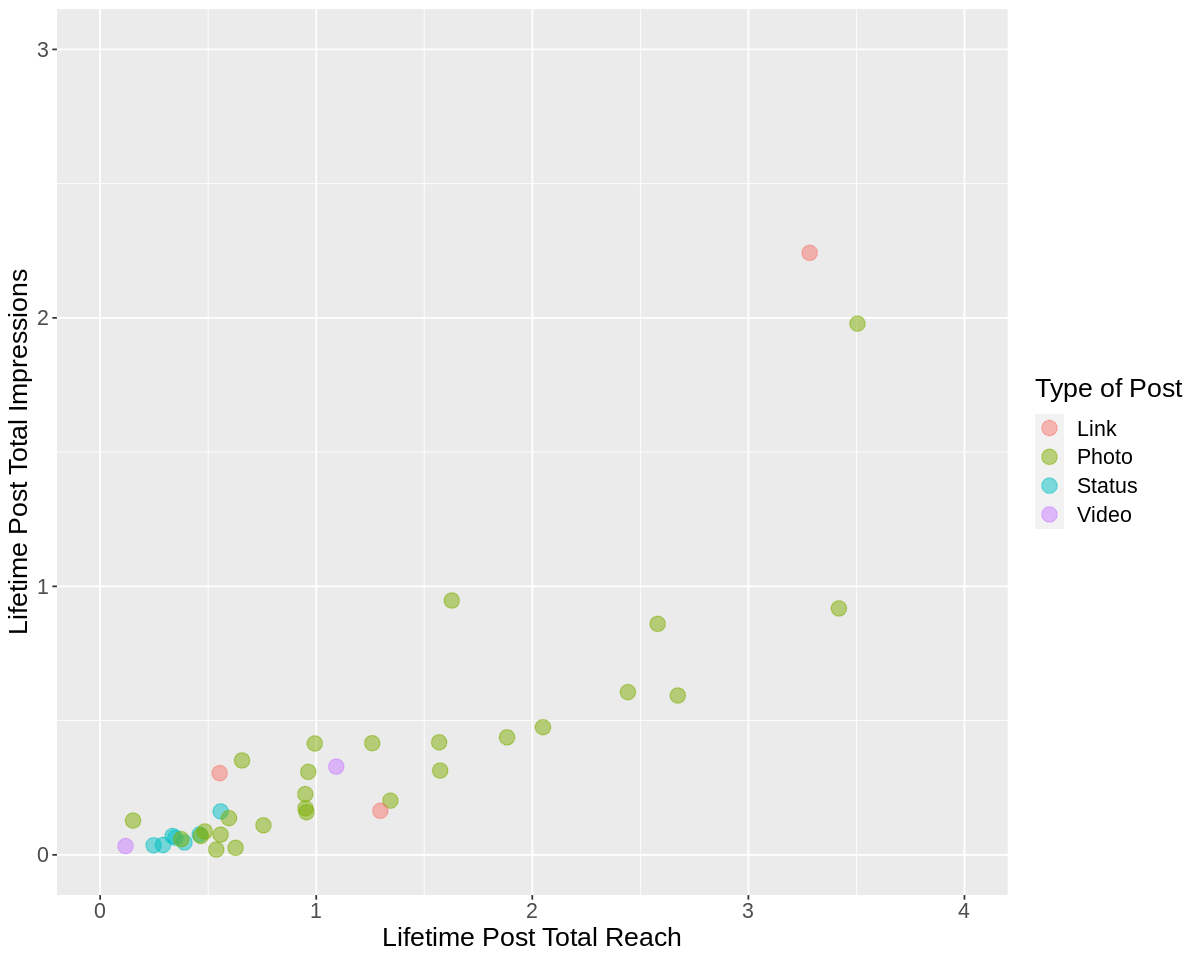

In [181]:
options(repr.plot.width=10, repr.plot.height=8)
test_unpaid_plot <- train_set_unpaid %>% mutate(Lifetime_Post_Total_Reach = scale(Lifetime_Post_Total_Reach),
                                              Lifetime_Post_Total_Impressions = scale(Lifetime_Post_Total_Impressions)) %>% 
    ggplot(aes(x = Lifetime_Post_Total_Reach, y = Lifetime_Post_Total_Impressions, color = Type)) +
    geom_point(alpha = 0.5, size = 4) +
    labs(color = "Type of Post", x = "Lifetime Post Total Reach", y = "Lifetime Post Total Impressions") +
    #xlim(NA, 4) + ylim(NA, 4) +
    scale_x_continuous(limits=c(0, 4)) +
    scale_y_continuous(limits=c(0, 3)) +
    theme(text = element_text(size = 16))

test_unpaid_plot

#### Balancing
We see the distribution of the type of posts is not equal so we should consider balancing. However, this introduces potential complications in further parts of our analysis, mainly the cross validation step. We find that balancing our data in this part of our analysis results in overestimated accuracies for our cross validation model later on. Additionally, we are hestitant to balance training set because this alternation is not reflected in our testing set, which can lead to more uncertainty. Because of these factors, we chose to leave our data unbalanced. We believe this will lead to less biased results when using our training data set further in our report. 

In [184]:
# Scrapped balancing step

#ups_recipe <- recipe(Type ~ Lifetime_Post_Total_Reach + Lifetime_Post_Total_Impressions, data = train_set_unpaid) %>%
#  step_upsample(Type, over_ratio = 1, skip = FALSE) %>%
#  prep()

# upsampled_cancer <- bake(ups_recipe, train_set_unpaid)

# upsampled_cancer %>%
#   group_by(Type) %>%
#   summarize(n = n())

### Pre-Process (Scale Data) for K-nn Classification
We must do this because: ________________

### Building our Model

We use the upscaled data into our tuning selection process as we need a balanced data set. Then by scaling the data and following the tidymodel recipes workflow, we collect the results from various values of k. Our base value of k is set to 3.

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")

unpaid_recipe <- recipe(Type ~ 
                        Lifetime_Post_Total_Reach + Lifetime_Post_Total_Impressions,
                        data = train_set_unpaid) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

unpaid_fit <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      # fit(data = upsampled_cancer)
      fit(data = train_set_unpaid)

      #fit_resamples(resamples = unpaid_vfold)

unpaid_val_predicted <- predict(unpaid_fit, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy <- unpaid_val_predicted %>%
    metrics(truth = Type, estimate = .pred_class)
    
unpaid_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.75000000
kap,multiclass,0.06896552


We found that our current accuracy against our validation set is roughly 75%. We will continue to tune our model in the following steps.

### Tuning our model

1. We will perform the cross validation technique with 10 folds to account for randomness.

In [14]:
set.seed(99)
#unpaid_vfold <- vfold_cv(upsampled_cancer, v = 10, strata = Type)
unpaid_vfold <- vfold_cv(train_set_unpaid, v = 10, strata = Type)

unpaid_fit_v2 <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = unpaid_vfold) %>% collect_metrics()
unpaid_fit_v2

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.8590000,10,0.02409074,Preprocessor1_Model1
roc_auc,hand_till,0.7702354,10,0.04136906,Preprocessor1_Model1


We see the accuracy of our model is around 86%.

2. Next we will perform a paramterization selection method to select a better value for K.

In [15]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_results <- workflow() %>%
  add_recipe(unpaid_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = unpaid_vfold, grid = 10) %>% 
  collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracies

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8511667,10,0.02721894,Preprocessor1_Model1
4,accuracy,multiclass,0.8631667,10,0.02451786,Preprocessor1_Model2
6,accuracy,multiclass,0.8434744,10,0.02435619,Preprocessor1_Model3
7,accuracy,multiclass,0.8474872,10,0.02398294,Preprocessor1_Model4
⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,accuracy,multiclass,0.8513333,10,0.02558478,Preprocessor1_Model6
12,accuracy,multiclass,0.8551795,10,0.02303849,Preprocessor1_Model7
13,accuracy,multiclass,0.8551795,10,0.02303849,Preprocessor1_Model8
14,accuracy,multiclass,0.8591795,10,0.02309284,Preprocessor1_Model9


3. Then using our collected metrics, we can visualize our accuracies to refine our value of K.

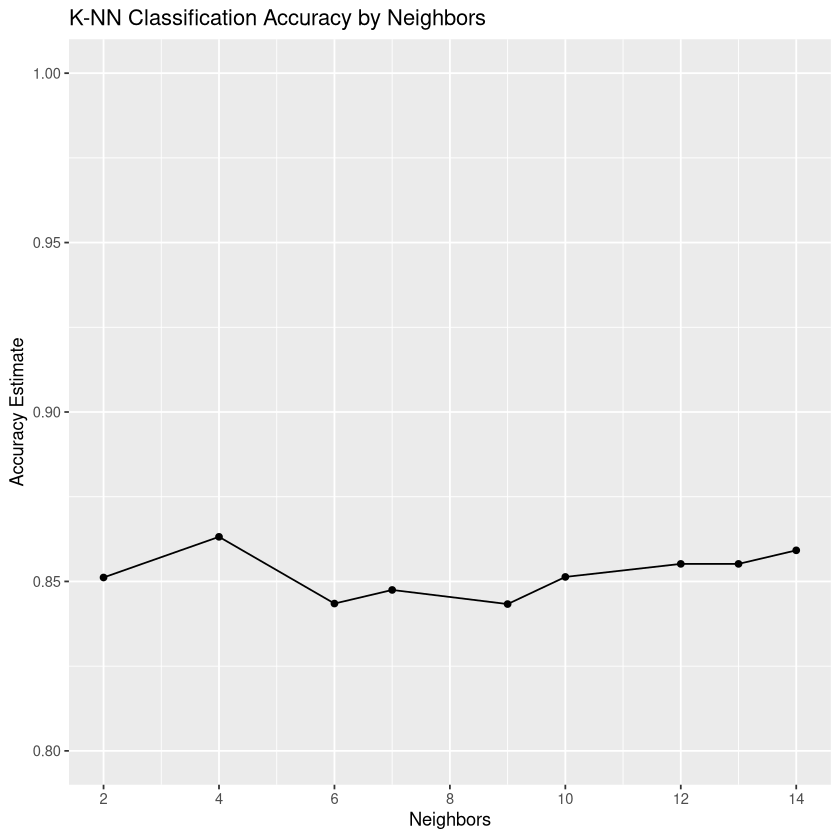

In [16]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "K-NN Classification Accuracy by Neighbors") +
      scale_x_continuous(breaks = seq(0, 16, by = 2)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [17]:
most_accurate_k <- knn_results %>% filter(.metric == "accuracy") %>% arrange(desc(mean)) %>% slice(1)
most_accurate_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,multiclass,0.8631667,10,0.02451786,Preprocessor1_Model2


The visualization suggests that K=4 averages the highest accuracy of ~86% from our 10 cross validation sets. We edit our model specification to take k=2 instead of k=3 as follows. After doing so, we can compare the accuracy of each model.

In [18]:
# we use the same recipe, change spec

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
  set_engine("kknn") %>%
  set_mode("classification")

unpaid_fit_tuned <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = train_set_unpaid) 
      #fit_resamples(resamples = unpaid_vfold)

unpaid_val_predicted_tuned <- predict(unpaid_fit_tuned, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy_tuned <- unpaid_val_predicted_tuned %>%
    metrics(truth = Type, estimate = .pred_class) %>% filter(.metric == "accuracy")

model_improvement <- unpaid_prediction_accuracy_tuned$.estimate - unpaid_prediction_accuracy$.estimate

unpaid_prediction_accuracy_tuned
print(model_improvement)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.75


[1] 0.0000000 0.6810345


After changing our model spec from 2 to 3, we see that the modifications to our model has increased our accuracy by roughly *5.56%* (our original accuracy was roughly *72.2%*) and thus we will choose the tuned model.

### EXPLAIN WHY LOW ACCURACY OCCURS
- We have 1 video observation in our testing set
- which after we have classified the only video value
- 

---------------------------------------------------------------------------------------------------------

### Additional Exploratory Analysis

In [19]:
mean_comment <- summ_train_unpaid$mean_comment
mean_like <- summ_train_unpaid$mean_like
mean_Total_Interactions <- summ_train_unpaid$mean_Total_Interactions
mean_share <- summ_train_unpaid$mean_share
type <- summ_train_unpaid$Type

test_df <- data.frame(mean_comment,mean_like,mean_Total_Interactions,mean_share,type)
test_df

fb_long <- test_df %>%
gather("Stat", "Value", -type)

fb_long


mean_comment,mean_like,mean_Total_Interactions,mean_share,type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.100000,100.9000,119.8000,15.80000,Link
6.404762,155.9905,186.5476,24.15238,Photo
6.880000,145.8400,179.4800,26.76000,Status
10.333333,216.0000,285.6667,59.33333,Video


type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_comment,3.100000
Photo,mean_comment,6.404762
Status,mean_comment,6.880000
Video,mean_comment,10.333333
⋮,⋮,⋮
Link,mean_share,15.80000
Photo,mean_share,24.15238
Status,mean_share,26.76000
Video,mean_share,59.33333


In [20]:
# test_df <- data.frame(
# mean_comment = c(4.0, 7.317073, 13.166667, 12.333333),
# mean_like = c(56.66667, 202.14634, 281.16667, 276.33333),
# mean_Total_Interactions = c(71.0000, 235.2683, 353.8333, 346.6667),
# mean_share = c(10.33333, 25.80488, 59.50000, 58.00000),
# type = c("Link", "Photo", "Status", "Video"))


# fb_long <- test_df %>%
# gather("Stat", "Value", -type)

# fb_long


In [21]:
filter_mean_like <- fb_long %>%
    filter(Stat == "mean_like")

filter_mean_like

type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_like,100.9000
Photo,mean_like,155.9905
Status,mean_like,145.8400
Video,mean_like,216.0000


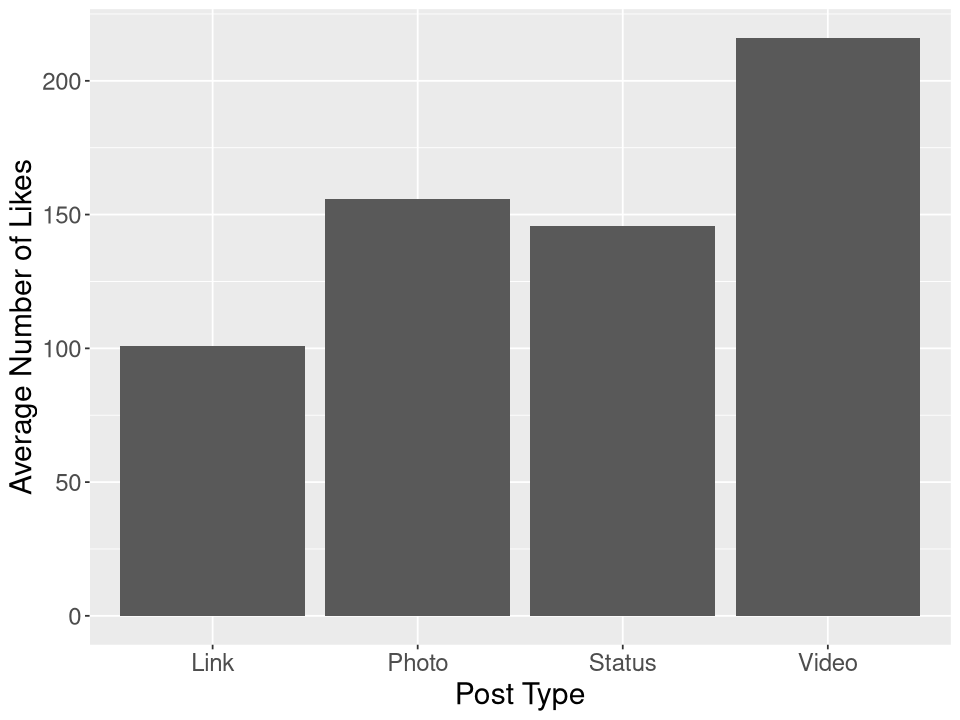

In [22]:
options(repr.plot.width = 8, repr.plot.height = 6) 

mean_likes_bar <- ggplot(filter_mean_like, aes(x = type, y = Value)) +
    geom_bar(stat = "identity") +
    labs(x = "Post Type", y = "Average Number of Likes") +
    theme(text = element_text(size = 18)) 

mean_likes_bar

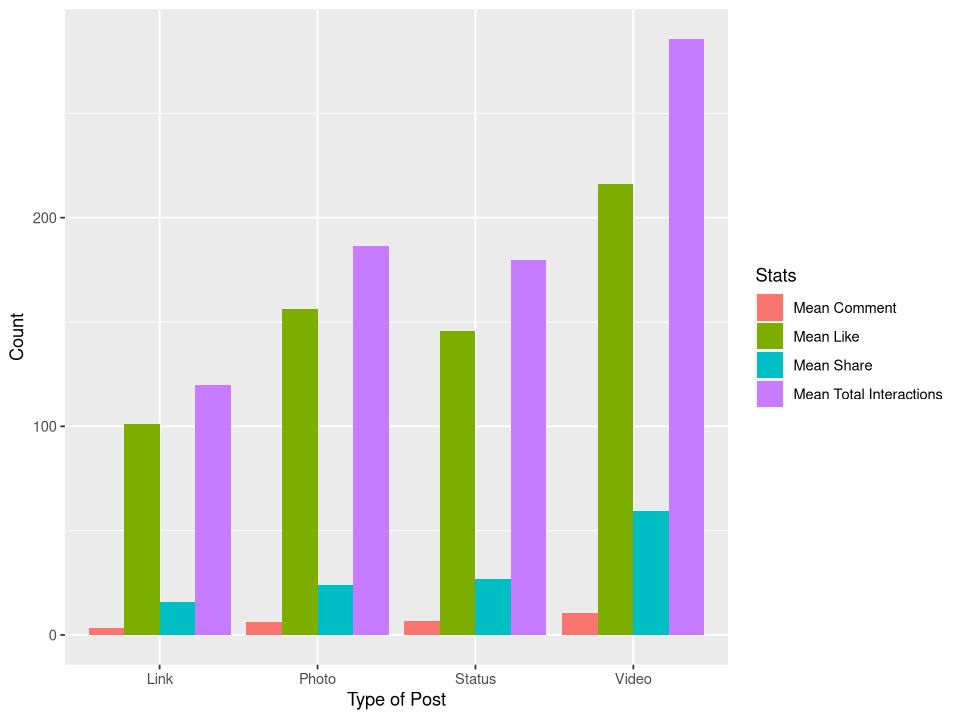

In [23]:
mean_fb <- ggplot(fb_long, aes(x = type, y = Value, fill = Stat)) +
    geom_col(position = "dodge") +
    labs(x = "Type of Post", y = "Count") +
    scale_fill_discrete(name = "Stats", labels = c("Mean Comment", "Mean Like", "Mean Share", "Mean Total Interactions"))

mean_fb

Warning message:
“Removed 21 rows containing missing values (geom_point).”


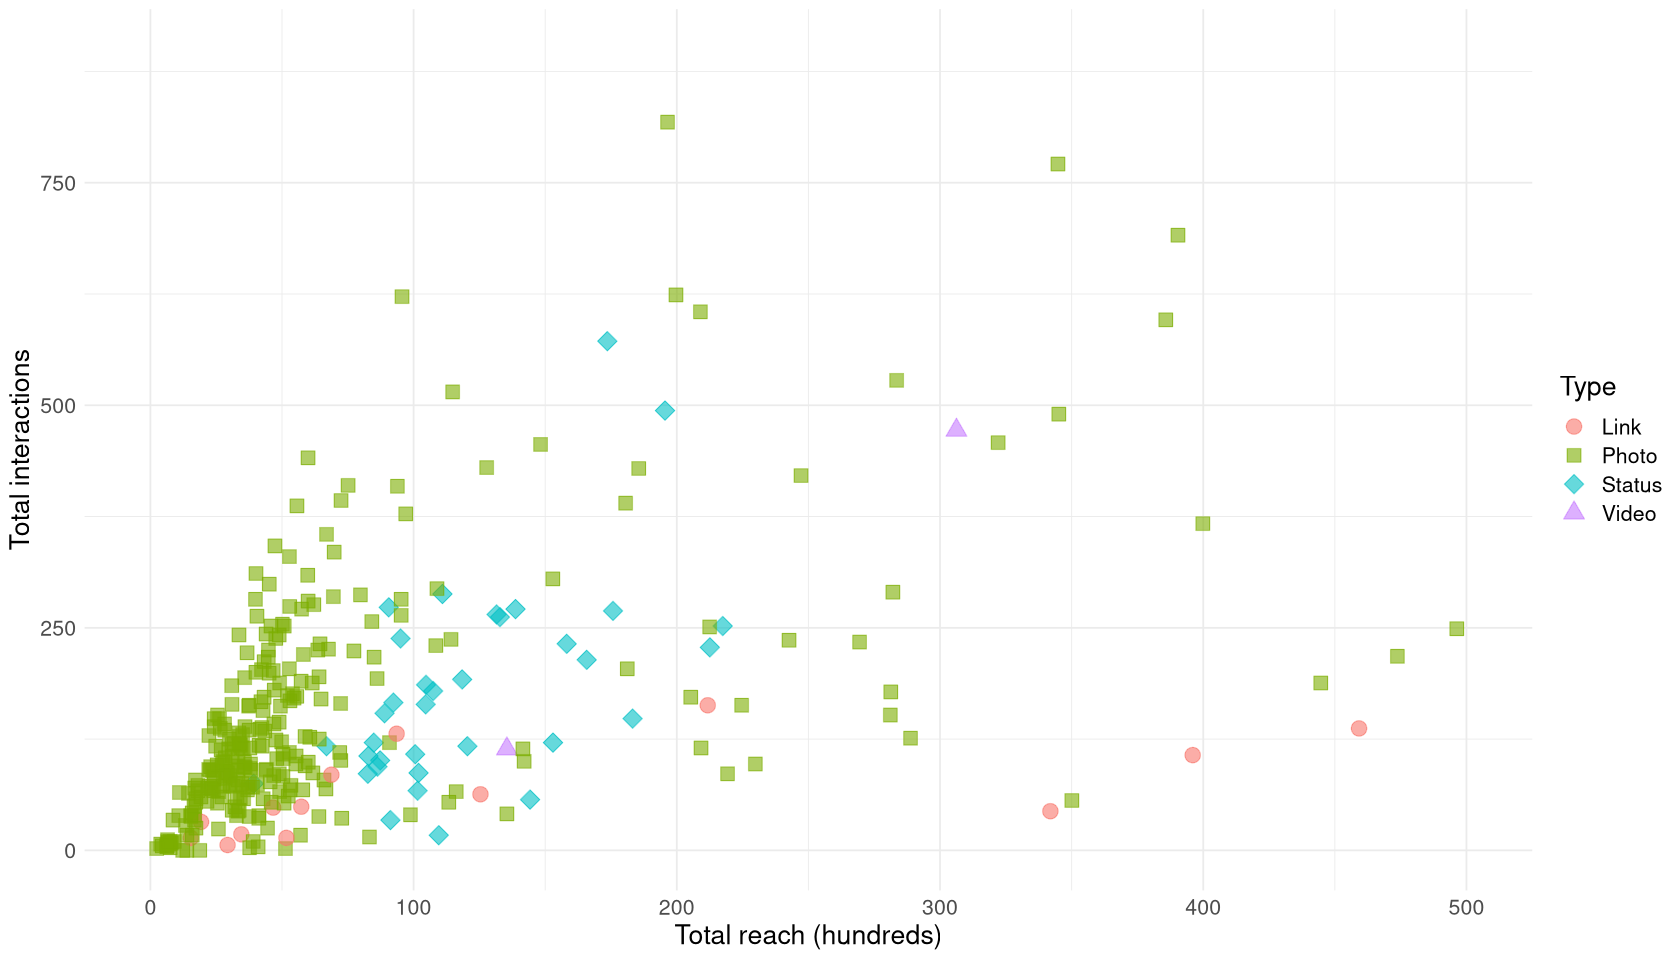

In [24]:
library(ggplot2)
unpaid_plot <- facebook_clean_unpaid %>% 
    ggplot(aes(x = Lifetime_Post_Total_Reach/100, y = Total_Interactions, shape=Type, color=Type, fill=Type))+
    geom_point(alpha=0.6, size=4)+
    labs(x="Total reach (hundreds)", y="Total interactions", group="Type")+
    scale_y_continuous(limits = c(0,900))+
    scale_x_continuous(limits = c(0,500))+
    scale_shape_manual(values = c(21,22,23,24)) +
    scale_size_manual(values=c(1,6,7,9))+
    theme_minimal()+
    theme(text = element_text(size = 16))
    options(repr.plot.width =14, repr.plot.height = 8) 
unpaid_plot

### Bibliography

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research. 69(9), 3341 - 3351. 

In [25]:
facebook

Page_total_likes,Type,Category,Post_Month,Post_Weekday,Post_Hour,Paid,Lifetime_Post_Total_Reach,Lifetime_Post_Total_Impressions,Lifetime_Engaged_Users,Lifetime_Post_Consumers,Lifetime_Post_Consumptions,Lifetime_Post_Impressions_by_people_who_have_liked_your_Page,Lifetime_Post_reach_by_people_who_like_your_Page,Lifetime_People_who_have_liked_your_Page_and_engaged_with_your_post,comment,like,share,Total_Interactions
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119
